In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import json
import random as random_
import re
from glob import iglob
import os
from typing import List, Dict, Tuple, Set, Any,  Union, Optional, Callable
from typing_extensions import TypedDict, Literal
from math import floor
import pandas as pd
import seaborn
import matplotlib.pyplot as plt 
from pprint import pprint
from sklearn.preprocessing import normalize

C:\Users\Jorge\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Users\Jorge\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\Users\Jorge\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:43: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated co

In [2]:
#!pip install --upgrade tensorflow

https://datascience.stackexchange.com/questions/43191/validation-loss-is-not-decreasing

In [3]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.8.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
DATASET_BASE = "../SpotMyFM/Ludwig/dataset-tools/python/out"
MFCCS  = f"{DATASET_BASE}/mfccs"
LABELS = f"{DATASET_BASE}/labels.json"
SUBGENERES = f"{DATASET_BASE}/subgeneres.json"
CHECKPOINT = "./checkpoint/saved_model.h5"
BATCH_SIZE = 26

SEED = random_.randint(0, 100)
random = random_.Random(SEED)

## JSON Declaration and other Dicts 

In [5]:


class N(TypedDict): # A number 
    N: Union[float, int]

class S(TypedDict): # A string
    S: str

class L(TypedDict): # A list of strings
    L: List[S]

class Track(TypedDict):
    # IDs
    PK: S
    mbid: S

    # Genres: 
    genre: S
    subgenres: L
    otherSubgenres: Optional[L]

    # Moods
    aggressive: Optional[N]
    happy: Optional[N]
    party: Optional[N]
    acoustic: Optional[N] 
    electronic: Optional[N]
    sad: Optional[N]
    relaxed: Optional[N]

    # Metadata
    preview: S
    name: Optional[S]
    artist: Optional[S]
    popularity: Optional[N]
    album: Optional[S]
    

class LabelsJson(TypedDict):
    tracks: Dict[str, Track]

class Mfcc(TypedDict):
    mfccs: np.ndarray
    track_id: str
    splits: int


In [6]:
def load_json(path:str) -> Dict[str, Any]:
    """Loads a json file 

    Args:
        path (str): json file path

    Returns:
        Dict: A dictionary indexed by a string
    """
    with open(path, "r") as f:
        return json.load(f)

In [7]:
def get_subgenres(parent_genre: str, subgenres: List[str]):
    """Get all subgenres of a given genre

    Args:
        parent_genre (str): 
        subgenres (List[str]): List of subgenres to match with a parent genre

    Returns:
        List[str]: List of subgenres
    """
    return list(filter(lambda s: parent_genre in s.split("---")[0] ,subgenres))

In [8]:
def load_mfccs(subgenres_list: List[str], subgenres: Dict[str, List[str]], labels: LabelsJson, search_path: str = MFCCS,  max_per_genre = None):
    
    track_set: Set[str] = set() # List of track ids among all subgenres_list subgenres
    
    genre_count: Dict[str, int] = {}
    
    track_splits: List[Mfcc] = [] 

    for g in subgenres_list:
        track_set.update(subgenres[g])

    for npy in iglob(search_path + '/**/*.npy', recursive=True):
        match = re.search(r"[a-zA-Z0-9]+.npy", npy)

        if (match and match.group(0)):
            track_id = match.group(0).replace(".npy", "")
            if track_id in track_set: 
                genre = labels["tracks"][track_id]["genre"]["S"]
                g_count = genre_count.get(genre, 0)
                
                if max_per_genre is not None and g_count > max_per_genre:
                    continue
                
                try:
                    mfccs_splits = np.load(npy)
                    track_splits.append({"mfccs": mfccs_splits, "track_id": track_id, "splits": len(mfccs_splits)})
                    genre_count[genre] = g_count + 1
                except IOError:
                    print(f"File {npy} not found")

    return track_splits
        

In [9]:
def normalize_data(data):
    return np.subtract(data,np.mean(data))

In [10]:
def train_test_val(ds: List[Mfcc], test=0.01, val=0.2):
    # TRAIN     
    train_slice = floor(len(ds) * (1 - val - test))
    train = ds[:train_slice]

    rest = ds[train_slice:]
    rest_slice =  floor(len(rest) * (1 - (test / ( test + val))))

    # TEST
    val = rest[:rest_slice]

    # VAL
    test = rest[rest_slice:]

    return train, test, val

## Tensorflow 

### Callbacks

In [11]:
class StopCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get("accuracy") or 0) > 0.99:
            self.model.stop_training = True

stop_callback = StopCallback()


def build_checkpoint_callback(out_file = CHECKPOINT):
    return tf.keras.callbacks.ModelCheckpoint(
        out_file,
        monitor='val_accuracy',
        save_best_only = True,
        verbose = True,

    )


In [12]:
target_dict = {"a": [1,2,3], "b": [2, 1]}
print(min([len(x) for x in target_dict.values()]))

2


In [13]:
class TrackDataGen(keras.utils.Sequence):
    
    def __init__(self, data: List[Mfcc],
                 target_f: Callable[[Track], Any],
                 labels: LabelsJson,
                 undersample = False,
                 oversample = False,
                 verbose = False,
                 filter = lambda t: True,
                 batch_size = BATCH_SIZE):
        
        self.batch_size = batch_size
        target_dict = {}
        X: List[np.ndarray] = []
        Y: List[str] = []

        for mfcc_ in data:
            track = labels["tracks"][mfcc_["track_id"]]
            
            if filter(track):
                target = target_f(track)
                mfccs = mfcc_["mfccs"]
                target_list = target_dict.get(str(target), [])
                for split in mfccs:
                    target_list.append([split, target])
                target_dict[str(target)] = target_list
        

        if verbose:
            print("Items Per Label:")
            for target, splits in target_dict.items():
                print(f"{target}: {len(splits)}")
            
        
        if undersample:
            limit = min([len(x) for x in target_dict.values()])
        elif oversample:
            limit = max([len(x) for x in target_dict.values()])
            
        else:
            limit = None
            
        for splits in target_dict.values():
            for split in splits[:limit]:
                X.append(split[0])
                Y.append(split[1])
            
            if oversample: 
                missing = limit - len(splits)
                
                oversample_candidates = list(splits)
                
                while len(oversample_candidates) < missing:
                    oversample_candidates.extend(list(splits))
                    
                random.shuffle(oversample_candidates)
                
                extra =  oversample_candidates[:missing]
                
                for value, tag in extra:
                    X.append(value)
                    Y.append(tag)
                    

        X_np = np.array(X)
        X_np = np.expand_dims(X_np, axis=3)
        Y_np = np.array(Y)

        if verbose:
            print(f"X shape: {X_np.shape} X dtype: {X_np.dtype} Y shape: {Y_np.shape} Y dtype: {Y_np.dtype}") 

        assert len(X_np) == len(Y_np)
        self.X, self.Y = self.unison_shuffled_copies(normalize_data(X_np), Y_np)
        
    @staticmethod
    def unison_shuffled_copies(a, b):
        assert len(a) == len(b), f"len(a) = {len(a)} != len(b) = {len(b)}"
        p = np.random.permutation(len(a))
        return a[p], b[p]

    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.Y[idx * self.batch_size:(idx + 1) * self.batch_size] 
        
        return batch_x, np.array(batch_y)
    
    def __len__(self):
        return len(self.X) // self.batch_size

## Target Functions

In [14]:
def genre_target(t: Track, genres2labels: Dict[str, int]) -> int:
    return genres2labels[t["genre"]["S"]]


def binary_genre_target(t: Track, genre: str):
    for sub in t["subgenres"]["L"] + t["otherSubgenres"]["L"]:
        if genre in sub["S"].split("---")[0]:
            return 1
    return 0

def mood_target(t: Track) -> List[float]:
    default: N = {"N": 0.5}

    acoustic =  (t.get("acoustic") or default)
    aggressive = t.get("aggressive") or default
    electronic = t.get("electronic") or default
    happy = t.get("happy") or default
    party = t.get("party") or default
    relaxed = t.get("relaxed") or default 
    sad = t.get("sad") or default
    return [1 if float(prob) > 0.5 else 0 for prob in [acoustic["N"], aggressive["N"], electronic["N"], happy["N"], party["N"], relaxed["N"], sad["N"]]]

def subgenre_target(t: Track, subgenres: List[str]) -> List[Literal[1, 0]]:
    track_subgenres = set([s["S"] for s in t["subgenres"]["L"]])
    return [1 if sub in track_subgenres else 0 for sub in subgenres]

In [15]:
def get_track_labels(track_id):
    track = labels["tracks"][track_id]
    return target_function(track)
    

In [16]:
def get_resnet18():
    if not os.path.exists("resnet18.h5"):
        !wget https://github.com/breadbread1984/resnet18-34/raw/master/models/resnet18.h5
    
    return keras.models.load_model("resnet18.h5")

In [17]:
def get_gtzan():
    if not os.path.exists("gtzan_ext.h5"):
        !wget https://github.com/JorgeRuizDev/SpotMyFM/raw/main/Ludwig/models/gtzan_ext.h5
    
    return keras.models.load_model("gtzan_ext.h5")

In [18]:
def build_CNN(label_count: int, activation: str, input_shape: Tuple[int], name="Sequential"):
    model = keras.models.Sequential([
        #keras.layers.Normalization(axis=-1, input_shape=shape),
        keras.Input(shape=shape),
        keras.layers.Conv2D(4, (3,3), activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(8, (3,3), activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.BatchNormalization(),
        
        keras.layers.Conv2D(16, (3,3), activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.BatchNormalization(),


        keras.layers.Flatten(),


        keras.layers.Dropout(0.3),

        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.1),

        #keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(label_count , activation=activation),  
    ])
    
    return model


In [19]:
from matplotlib import pyplot as plt

def plot_history(history):
    # plot accuracy
    if not history:
        return

    # plot categorical accuracy
    plt.plot(history.history[metrics[0]])
    plt.plot(history.history[f'val_{metrics[0]}'])

    
    plt.plot(history.history['loss'], label='train', marker="+" )
    plt.plot(history.history['val_loss'], label='test', marker="+")
    plt.legend()
    plt.show()

In [20]:
def one_gen_per_track_filer(t: Track):
    genres = set()
    
    for sub in t["subgenres"]["L"] + t["otherSubgenres"]["L"]:
        genre = sub["S"].split("---")[0]
        genres.add(genre)
    
    return True if len(genres) == 1 else False

In [21]:
def build_ova(genres: List[str], labels: LabelsJson, train: List[Mfcc], val: List[Mfcc]):
    
    models = []
    for i, genre in enumerate(genres):
        print(f"Training {genre}")
        checkpoint_file = f"./ova/{i}-{genre}.h5"
        
             
        # Prepare the Data + Binary Label
        train_generator = TrackDataGen(train, lambda x: binary_genre_target(x, genre),  labels, oversample=True, verbose=True, filter = one_gen_per_track_filer )
        
        validation_generator = TrackDataGen(val, lambda x: binary_genre_target(x, genre),  labels, undersample=True, filter = one_gen_per_track_filer),
        
        shape = train_generator[0][0][0].shape
    
        
        model = build_CNN(1, "sigmoid", input_shape=shape,name=genre)
        checkpoint_callback = build_checkpoint_callback(checkpoint_file)
        model.compile(optimizer = keras.optimizers.Adam(), loss = "binary_crossentropy", metrics = ["accuracy"])

        
        history = model.fit(train_generator,
                    validation_data = validation_generator, 
                    epochs=50,
                    callbacks = [stop_callback, checkpoint_callback],
                    batch_size = BATCH_SIZE
                )

        loaded_model = keras.models.load_model(checkpoint_file)
        del validation_generator
        del train_generator
        del model
        if history is not None:
            plot_history(history)
        

        models.append((genre, loaded_model ))
    
    return models

## Main Function

#### Prepare the Data

In [22]:
labels: LabelsJson = load_json(LABELS) # type: ignore

# Track Genres:
genres = list(set([t["genre"]["S"] for t in labels["tracks"].values()]))
genres2labels = {g: i for i,g in enumerate(genres)}
labels2genres = {i: g for i,g in enumerate(genres)}
# Track Subgenres: 
subgenres: Dict[str, List[str]] = load_json(SUBGENERES)
subgenre_list = list(subgenres.keys())


    

In [23]:
pprint(genres2labels)
pprint(labels2genres)

{'blues': 3,
 'classical': 1,
 'electronic': 4,
 'funk / soul': 9,
 'hip hop': 6,
 'jazz': 5,
 'latin': 0,
 'pop': 2,
 'reggae': 8,
 'rock': 7}
{0: 'latin',
 1: 'classical',
 2: 'pop',
 3: 'blues',
 4: 'electronic',
 5: 'jazz',
 6: 'hip hop',
 7: 'rock',
 8: 'reggae',
 9: 'funk / soul'}


In [24]:
print(f"All Subgenres: ")
genre_sub = {}
for s in subgenre_list:
    main = s.split("---")[0]
    subgenres_ = genre_sub.get(main, [])
    subgenres_.append(s)
    genre_sub[main] = subgenres_
    
pprint(genre_sub)

All Subgenres: 
{'blues': ['blues---country blues', 'blues---electric blues'],
 'classical': ['classical---classical',
               'classical---romantic',
               'classical---baroque',
               'classical---modern',
               'classical---opera'],
 'electronic': ['electronic---ambient',
                'electronic---synth-pop',
                'electronic---disco',
                'electronic---house',
                'electronic---drum n bass',
                'electronic---downtempo',
                'electronic---new wave',
                'electronic---electro',
                'electronic---trip hop'],
 'funk / soul': ['funk / soul---disco',
                 'funk / soul---rhythm & blues',
                 'funk / soul---soul'],
 'hip hop': ['hip hop---trap',
             'hip hop---pop rap',
             'hip hop---instrumental',
             'hip hop---conscious',
             'hip hop---trip hop',
             'hip hop---gangsta'],
 'jazz': ['jazz---contem

In [25]:
subgenre_set = set()
for s in [get_subgenres(g, subgenre_list) for g in ["jazz", "blues", "pop", "funk / soul", "rock", "electronic", "hip hop"]]:
    subgenre_set.update(s)

#subgenre_list = list(subgenre_set)

#subgenre_list = get_subgenres("electronic", subgenre_list)
print(subgenre_list)

['latin---reggaeton', 'pop---indie pop', 'rock---pop rock', 'hip hop---trap', 'rock---prog rock', 'funk / soul---disco', 'latin---salsa', 'funk / soul---rhythm & blues', 'funk / soul---soul', 'rock---punk', 'blues---country blues', 'pop---europop', 'reggae', 'rock---alternative rock', 'rock---heavy metal', 'blues---electric blues', 'jazz---contemporary jazz', 'electronic---ambient', 'rock---hard rock', 'electronic---synth-pop', 'hip hop---pop rap', 'electronic---disco', 'electronic---house', 'classical---classical', 'classical---romantic', 'latin---flamenco', 'rock---nu metal', 'pop---ballad', 'rock---death metal', 'hip hop---instrumental', 'rock---goth rock', 'electronic---drum n bass', 'hip hop---conscious', 'electronic---downtempo', 'jazz---swing', 'rock---post rock', 'classical---baroque', 'classical---modern', 'latin---samba', 'electronic---new wave', 'rock---shoegaze', 'electronic---electro', 'jazz---soul-jazz', 'electronic---trip hop', 'classical---opera', 'rock---art rock', 'ro

In [26]:
operation = "multiclass"

if operation  == "multilabel":
    activation, loss, metrics = "sigmoid", "binary_crossentropy", \
        ["categorical_accuracy", keras.metrics.BinaryAccuracy(name="binary_accuracy", threshold=0.5)]
    target_function = lambda t: subgenre_target(t, subgenre_list)

    label_count = len(subgenre_list)
elif operation  == "mood":
    activation, loss, metrics = "sigmoid", "binary_crossentropy", ["categorical_accuracy", keras.metrics.BinaryAccuracy(name="binary_accuracy", threshold=0.5)]
    target_function = lambda t: mood_target(t)
    label_count = 7
elif operation  == "multiclass":
    activation, loss, metrics = "softmax", "sparse_categorical_crossentropy", ["accuracy"]
    target_function = lambda t: genre_target(t, genres2labels)
    label_count = len(genres)
else:
    raise ValueError("Invalid Type")

#### Load the Data

#### Train the Model

In [28]:
mfccs = load_mfccs(subgenre_list, subgenres,  labels)
random.shuffle(mfccs)

train, test, val = train_test_val(mfccs)

print(f"train {len(train)} + test {len(test)} + val {len(val)} = {len(train) + len(test) + len(val)}" )

# Initialize the dataset generators 
train_generator = TrackDataGen(train, target_function,  labels, oversample=True)
test_generator = TrackDataGen(test, target_function,  labels)
validation_generator = TrackDataGen(val, target_function,  labels)

shape = train_generator[0][0][0].shape

print(f"shape: {shape}")


train 8922 + test 113 + val 2259 = 11294
shape: (32, 130, 1)


In [ ]:
ova_models = build_ova(genres, labels, train, val)

In [ ]:
def ensemble_ova(models: List[tf.keras.Model], input_shape: Tuple[int]):
    input_layer = keras.Input(shape=input_shape)
    input_norm = keras.layers.Normalization(axis=-1, name="Normalization")(input_layer) # keras.Input(shape=input_shape) #
    input_norm.trainable = True
    input_norm = input_layer
    #input_layer = input_layer(keras.Input(shape=input_shape))

    
    
    #models[0][1].summary()
    
    for genre, model in models:
                
        #model.name = genre

        model.layers[0] = keras.Input(shape=input_shape) # Remove the input normalization layer
        model.trainable = False

    
    
    model_outputs = [model(input_norm) for _, model in models]

    
    ova_output = keras.layers.Concatenate()(model_outputs)

    ova = keras.Model(inputs=input_layer, outputs=ova_output)

    ova.summary()
    return ova

In [ ]:
model = ova = ensemble_ova(ova_models, shape)
ova.compile(optimizer = keras.optimizers.Adam(), loss = "sparse_categorical_crossentropy", metrics = ["accuracy", tf.keras.metrics.BinaryAccuracy()])
#train_ova(ova)


ova.evaluate(validation_generator)
ova.save("ova.h5")


In [ ]:
hits = 0
print(genres)
for i, v in enumerate(val):
    real_res = res = ova.predict(normalize_data(v["mfccs"]))
    #print(res)
    res = res.sum(axis=0)
    lbl = res.argmax()
    
    real_lbl = labels["tracks"][v["track_id"]]["genre"]["S"]
    

    if (genres[lbl] == real_lbl):
        hits += 1
        #print(hits/max(i,1))
    else:
        continue
        print(f"{genres[lbl]} != {real_lbl} :: {res}")
        print(real_res)
        print(res)
    
    
print(hits / len(val))


In [ ]:
test_track = val[206]

input_data = normalize_data(test_track["mfccs"])
track_data = labels["tracks"][test_track["track_id"]]
print(track_data["subgenres"])

print(input_data.shape)
print(track_data["PK"])
input_data = np.expand_dims(input_data, axis = 3)
res = ova.predict(input_data)
print(res.sum(axis=0))
print(labels2genres[np.argmax(res.sum(axis=0))])
pred_genre = ["", 0]

for genre, model in ova_models:
    ova_res = model.predict(input_data)
    if False:
        pred_genre = genre, ova_res
    print(f"{genre}: {ova_res}")

print(f"{pred_genre} (real genre: {labels2genres[test_label]})")
for r, l in zip(res, lbl):
    break
    print(r)
    continue
    
    pred = np.argmax(r)
    print(f"{l} == {pred}")

In [ ]:
!zip ova.zip ./ova/*

In [ ]:
print(shape)

In [29]:
if True:
    conv_base = keras.applications.EfficientNetB0(
                    include_top = False, 
                    weights = "imagenet",
                    drop_connect_rate=0.8
                    )

    

    model = keras.models.Sequential([
                                    keras.layers.Conv2D(3,(3,3),padding='same', input_shape=shape ), 
                                    conv_base, 
                                    #keras.layers.BatchNormalization(),
                                    #keras.layers.GlobalAveragePooling2D(),
                                    keras.layers.BatchNormalization(),
                                    #keras.layers.Dropout(0.5),
                                    #keras.layers.Dense(512, activation="relu"),
                                    keras.layers.Flatten(),
                                    keras.layers.Dropout(0.3),
                                     
                                    keras.layers.Dense(512, activation="relu"),

                                    #keras.layers.Dense(256, activation="relu"),
                                    #keras.layers.Dropout(0.1),
                                    keras.layers.Dense(label_count , activation = activation)])

else:
    model = build_CNN(label_count , activation, shape)
model.compile(optimizer = keras.optimizers.Adam(), loss = loss, metrics = metrics)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 130, 3)        30        
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 batch_normalization (BatchN  (None, 1, 4, 1280)       5120      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dropout (Dropout)           (None, 5120)              0         
                                                                 
 dense (Dense)               (None, 512)               2621952   
                                                        

In [34]:

# Build and train the net 
#model = build_network("multilabel", labels=len(subgenre_list), shape=shape )
history = model.fit(train_generator,
                    validation_data = validation_generator, 
                    epochs=6,
                    
                    callbacks = [stop_callback, build_checkpoint_callback()],
                    batch_size = BATCH_SIZE
                )


Epoch 1/6
9775/9775 [==============================] - ETA: 0s - loss: 0.6784 - accuracy: 0.7768
Epoch 1: val_accuracy improved from -inf to 0.54947, saving model to ./checkpoint\saved_model.h5
9775/9775 [==============================] - 514s 53ms/step - loss: 0.6784 - accuracy: 0.7768 - val_loss: 1.6387 - val_accuracy: 0.5495
Epoch 2/6
9775/9775 [==============================] - ETA: 0s - loss: 0.5472 - accuracy: 0.8189
Epoch 2: val_accuracy improved from 0.54947 to 0.56486, saving model to ./checkpoint\saved_model.h5
9775/9775 [==============================] - 509s 52ms/step - loss: 0.5472 - accuracy: 0.8189 - val_loss: 1.5783 - val_accuracy: 0.5649
Epoch 3/6
9774/9775 [============================>.] - ETA: 0s - loss: 0.4566 - accuracy: 0.8489
Epoch 3: val_accuracy did not improve from 0.56486
9775/9775 [==============================] - 507s 52ms/step - loss: 0.4566 - accuracy: 0.8489 - val_loss: 1.6537 - val_accuracy: 0.5493
Epoch 4/6
9775/9775 [==============================] 

In [ ]:
model = keras.models.load_model("./checkpoint/saved_model.h5")

In [35]:
model.evaluate(validation_generator)

800/800 [==============================] - 12s 15ms/step - loss: 1.9092 - accuracy: 0.5512


[1.9091949462890625, 0.5512019395828247]

Accuracy: 0.5984949092518813
tf.Tensor(
[[115   5   4   4  18  21   6  14   1  10]
 [  0 154   0   4   8   6   0   3   0   1]
 [  8   1  28   2  49   3   1  35   0  12]
 [  3   1   1  48   9   8   0  44   0   6]
 [ 16   3  16   1 225  11  32  67   0  36]
 [  7   2   2  18  15  74   3  15   1  15]
 [  3   0   4   0  40   4 129  12   2   8]
 [  8   6  15  11 101  18   8 535   4  10]
 [  5   0   0   0   6   0   2   8   1   2]
 [  4   2   7   6  32  13   6  12   0  43]], shape=(10, 10), dtype=int32)


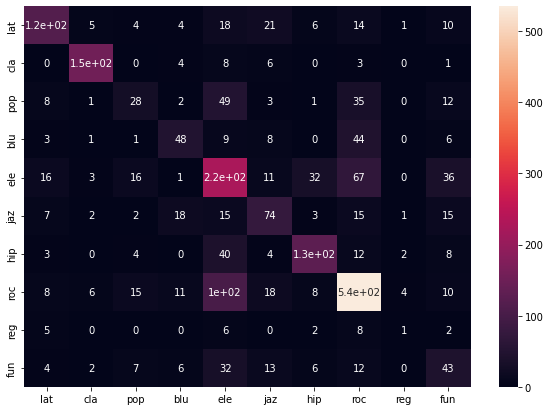

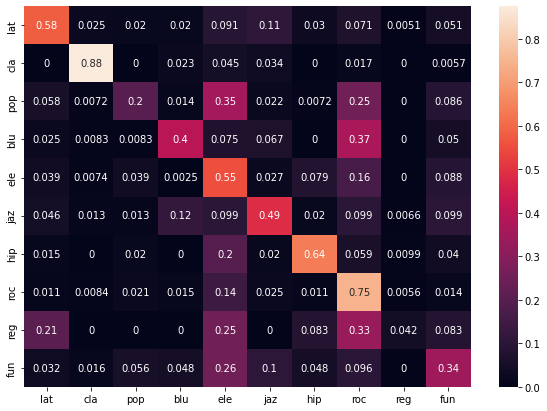

In [36]:
from sklearn.preprocessing import normalize
if operation == "multiclass":
    import seaborn as sn
    def conf_matrix(dataset: List[Mfcc]):
        real_labels = []
        pred_labels = []
        hit = 0

        for track in dataset:
            
            res = model.predict(normalize_data(np.expand_dims(track["mfccs"], axis=3)))
            
            res_sum = res.sum(axis=0)
            pred = np.argmax(res_sum)
            real = get_track_labels(track["track_id"])
            
            pred_labels.append(pred)
            real_labels.append(real)
            if pred == real:
                hit +=1 
        print(f"Accuracy: {hit / len(real_labels)}")
        conf_m = tf.math.confusion_matrix(labels=real_labels, predictions=pred_labels )
        
        norm_conf_m = normalize(conf_m, axis=1, norm='l1') 
        
        print(conf_m)
        
        genres = [labels2genres.get(i, "")[:3] for i in range(len(labels2genres))]
        df_cm = pd.DataFrame(conf_m, 
                             index=genres,columns=genres, 
                             dtype=np.int32)

        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True)
        
        df_cm = pd.DataFrame(norm_conf_m, 
                             index=genres,columns=genres, 
                             dtype=np.float32)

        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True)
    conf_matrix(val)
    

In [ ]:
if operation == "mood":
    for track in val:
        print(track["track_id"])
        track_label = get_track_labels(track["track_id"])
        pred = model.predict(track["mfccs"])
        res = pred.mean(axis=0)
        res = [1 if pred > 0.5 else 0 for pred in res]
        print(f"Pred: {res}")
        print(f"Res : {track_label}")

#### Analyze the Results 

In [ ]:
track = test[8]
res = model.predict(track["mfccs"])
print(res)
print(res.sum(axis=0))
print([1 if x > 0.5 * track["splits"] else 0 for x in res.sum(axis=0)])
print(target_function(labels["tracks"][track["track_id"]]))


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
def plot_conf_matrix(model: keras.Model, data: List[Mfcc]):

    predicted = []
    real = []

    for track in data:
        res = model.predict(track["mfccs"])
        res_sum = res.sum(axis=0)
        res = [1 if i > 0.5 * track["splits"] else 0 for i in res_sum]
        predicted.append(res)
        real.append(get_track_labels(track["track_id"]))
    

    
    print(np.mean(tf.keras.metrics.binary_accuracy(real, predicted, )))
    
    for r, p in zip(real, predicted):
        r_p = np.sum(r, p, axis = 0)
    
    assert len(predicted) == len(real)
    
    conf_m = multilabel_confusion_matrix(predicted, real)
    print(conf_m)
    print(np.array(conf_m).sum(axis=0))
    return 
    df_cm = pd.DataFrame(conf_m, index=genres, # type: ignore
                  columns=genres, dtype=np.int8)
    #plt.figure(figsize = (10,7))
    #seaborn.heatmap(df_cm, annot=True)   

plot_conf_matrix(model,val)